# Eindopdracht Data-science opleiding

## Vragen
In deze opdracht wordt de bewegingsdata afkomstig van 7 kandidaten op basis van fitbit-data geanalyseerd. Per kandidaat worden de volgende vragen beantwoord:
- Wat is het gemiddeld aantal stappen per dag?
- Wat is de trend voor het bewegen?
- Wanneer worden de 10.000 stappen per dag bereikt? En voor elke dag en gemiddeld voor elke weekdag (ma t/m zo).
- Hoe groot is de kans op beweging op een gegeven tijdstip op een gegeven dag?
- Wanneer is de grootste intensiteit van bewegen?

## Deel 1 Data voorbereiding

In dit eerste deel vindt de data voorbereiding plaats. In Oracle zijn de 7 csv bestanden via import functie in SQL-developer in geladen in de database/user fitbit in tabel FB_metingen.

In [31]:
###
# importeren van benodigde packages
###
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import dates
import seaborn as sns

#import pymongo
#from pymongo import MongoClient
from datetime import datetime
from datetime import date

## Inlezen data

Controleren welke bestanden er allemaal zijn.

In [32]:
for file in os.listdir('.'):
    if file.endswith(".csv"):
        print(file)

1119.csv
1120.csv
1121.csv
1122.csv
1123.csv
1124.csv
1125.csv
AirPassengers.csv
Fitbit_klasse.csv
fitbit_schoon.csv
Fitbit_TS.csv
Fitbit_TS1125.csv
ionosphere.csv
K1119wd_0.csv
K1119wd_1.csv
K1119wd_2.csv
K1119wd_3.csv
K1119wd_4.csv
K1119wd_5.csv
K1119wd_6.csv
maandag1119Niv.csv
maandag1119uur.csv
MaxStapDag.csv
mets_freq.csv
stap_freq.csv
TiendStap.csv
TiendStapUur.csv


In [33]:
# Lees alleen de bestanden van de kandidaten in.
FB_l =[pd.read_csv(file,parse_dates=['date']) for file in os.listdir('.') if file in ['1119.csv','1120.csv','1121.csv','1122.csv','1123.csv','1124.csv','1125.csv'] ]

In [34]:
# Zet de lijst met per kandidaat een dataframe om in een dataframe met alle metingen.
FB_df = pd.concat(FB_l)

## Betekenis gegevens Fitbit
In Fitbit (API en Help) documentatie is gezocht naar de betekenis van de verschillende gegevens in de data (https://dev.fitbit.com/docs/activity/#activity-logging , https://help.fitbit.com/articles/en_US/Help_article/1379)
- Mets: METs are widely used as indicators for exercise intensity
- Level:  reflects calculated activity level for that time period (0 - sedentary; 1 - lightly active; 2 - fairly active; 3 - very active). 
- Calories, Steps and Distance spreken voor zich.

**Voor het vervolg gebruiken we allen de stappen**

In [35]:
# Geef kolommen nieuwe namen
FB_df.columns=['T_Nr', 'FB_Nr', 'Datum', 'Cal','Mets','Niv','Stap','Afst']

In [36]:
FB_df = FB_df.drop(['FB_Nr','Cal','Mets','Niv'], 1)

### Opbouw dataset
Als het goed is hebben we nu een dataframe. Met head en tail methoden een deel van de inhoud bekijken.

In [37]:
type(FB_df)

pandas.core.frame.DataFrame

In [38]:
print(FB_df.head(3))
print(FB_df.tail(3))

   T_Nr               Datum  Stap  Afst
0  1119 2014-12-01 00:00:00   0.0   0.0
1  1119 2014-12-01 00:01:00   0.0   0.0
2  1119 2014-12-01 00:02:00   0.0   0.0
       T_Nr               Datum  Stap  Afst
86397  1125 2015-03-19 23:57:00   0.0   0.0
86398  1125 2015-03-19 23:58:00   0.0   0.0
86399  1125 2015-03-19 23:59:00   0.0   0.0


### Datakwaliteit
Is de de hoeveelheid data in elk bestand evenveel. Oftewel hoe lang zijn de periodes waarin de verschillende fitbits activiteit hebben geregistreerd?

Eerst maar eens het treatment identificatie nummer isoleren, zodat we ook bewerkingen per kandidaat kunnen uitvoeren.


In [39]:
fitbits_l=FB_df['T_Nr'].unique()
print(fitbits_l)

[1119 1120 1121 1122 1123 1124 1125]


Hieronder kijken we hoe lang de periode met metingen per kandidaat (fitbit) is.

In [40]:
print("id\tstartdatum\t\teinddatum\t\tperiode") #kopregel gescheiden door tabs (=\t)
for t in fitbits_l:
    treatment_b = FB_df['T_Nr']==t
    treatment_df = FB_df[treatment_b]
    start = treatment_df.iloc[0,1] #startdatum staat op eerste regel in kolom Datum
    end = treatment_df.iloc[len(treatment_df)-1,1] #einddatum staat op laatste regel (=lengte van de panda - 1) in kolom Datum
    delta=end - start
    treat_id=treatment_df.iloc[0,0] #haal het fitbit id op. Komt overeen met naam van de file.
    print(treat_id,": ",start," ",end," ",delta)

id	startdatum		einddatum		periode
1119 :  2014-12-01 00:00:00   2015-07-31 23:59:00   242 days 23:59:00
1120 :  2014-12-01 00:00:00   2015-07-31 23:59:00   242 days 23:59:00
1121 :  2015-01-19 00:00:00   2015-07-15 23:59:00   177 days 23:59:00
1122 :  2015-01-19 00:00:00   2015-03-19 23:59:00   59 days 23:59:00
1123 :  2014-12-01 00:00:00   2015-07-31 23:59:00   242 days 23:59:00
1124 :  2014-12-01 00:00:00   2015-07-31 23:59:00   242 days 23:59:00
1125 :  2015-01-19 00:00:00   2015-03-19 23:59:00   59 days 23:59:00


Verschillende periodes per kandidaat.

Hoe staat het met de metingen gedurende de hele periode. Zijn er momenten dat er geen metingen zijn of geen beweging is geregistreerd (fitbit niet gedragen bijv.).

## Vraag 1. Wat is het gemiddeld aantal stappen per dag?
voor de niet geschoonde data is het gemiddelde aantal stappen per kandidaat per dag:

In [41]:
StapGem_df = (FB_df.groupby(['T_Nr']).mean()['Stap'].reset_index())
StapGem_df['Stap gem dag']=StapGem_df['Stap']*1440

In [42]:
StapGem_df

,T_Nr,Stap,Stap gem dag
0,1119,9.819276,14139.757202
1,1120,4.888566,7039.534979
2,1121,3.594390,5175.920904
3,1122,13.262905,19098.583333
4,1123,5.074874,7307.818930
5,1124,2.670456,3845.456790
6,1125,8.909664,12829.916667


### Aantal stappen per dag

In [43]:
#voeg een kolom toe waar alleen de datum in staat (dus zonder tijd), zodat we per dag het aantal stappen kunnen zien.
FB_df['dateOnly'] = FB_df['Datum'].dt.date 

In [44]:
### Bereken totaal aantal stappen per dag.
StepsPeriod_df=FB_df.groupby(['T_Nr', 'dateOnly']).sum()['Stap'].reset_index()

In [45]:
StepsPeriod_df

,T_Nr,dateOnly,Stap
0,1119,2014-12-01,0.0
1,1119,2014-12-02,0.0
2,1119,2014-12-03,0.0
3,1119,2014-12-04,0.0
4,1119,2014-12-05,0.0
5,1119,2014-12-06,0.0
6,1119,2014-12-07,0.0
7,1119,2014-12-08,0.0
8,1119,2014-12-09,0.0
9,1119,2014-12-10,0.0


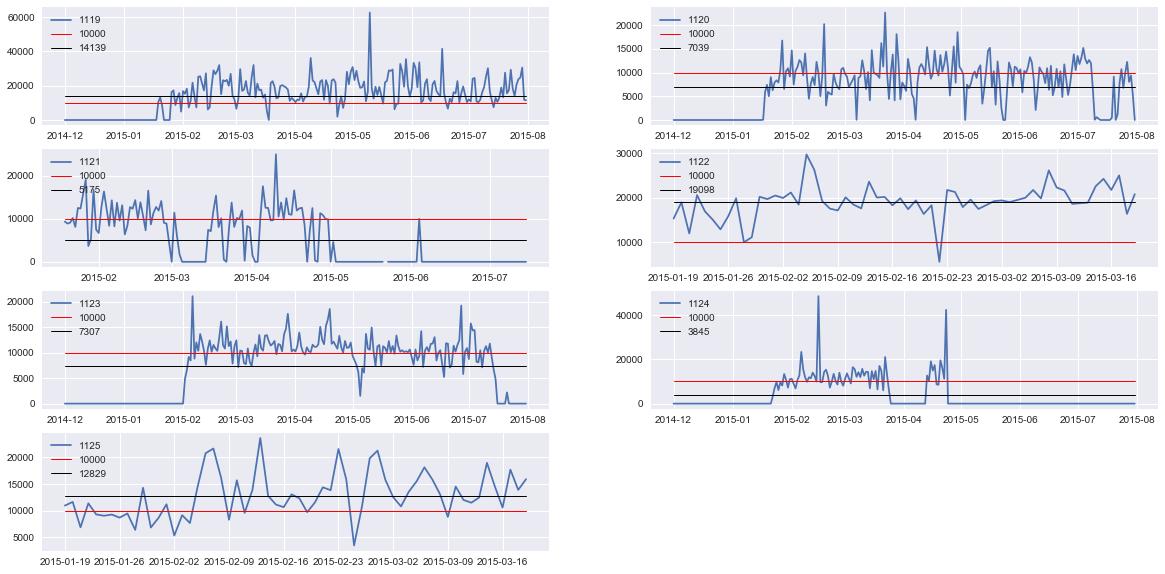

In [46]:
### en maak er eeen plot van.
stepsPlots = pl.figure(figsize=(20,10))

for idx,t in enumerate(fitbits_l):
    treatment_b = StepsPeriod_df['T_Nr']==t
    SPT_df = StepsPeriod_df[treatment_b]
    pl.subplot(4,2,idx+1)
    pl.plot(SPT_df['dateOnly'],SPT_df['Stap'],label=SPT_df.iloc[0,0])
    x1=SPT_df.iloc[0,1]
    x2=SPT_df.iloc[len(SPT_df)-1,1]
    ygem=int(StapGem_df.ix[(StapGem_df['T_Nr']==t),2])
    pl.plot([x1,x2 ], [10000, 10000], color='r', linestyle='-', linewidth=1,label='10000')
    pl.plot([x1,x2 ], [ygem, ygem], color='k', linestyle='-', linewidth=1,label=ygem)
    pl.legend(loc='upper left')

pl.show()

Bij elke kandidaat zijn er dagen dat de hoeveelheid beweging nul is en bij Fitbit nr 1121 ontbreekt er data voor de steps en  bij 1120 is er een periode waarin het aantal stappen erg laag is.

Eens kijken wanneer de eerste meting, dus een waarde in steps boven nul, bij de verschillende kandidaten voorkomt.

In [47]:
for t in fitbits_l:
    eersteStap_b = FB_df['Stap']>0 # maak boolean met True als stapwaarde in meting groter dan nul is.
    treatment_b=FB_df['T_Nr']==t   # maak boolean voor elke kandidaat
    print(FB_df[eersteStap_b & treatment_b].iloc[[0],[0,3,2]]) # selecteer per kandidaat de eerste 
                                                               # rij met een stap > 0 en laat de waarden 
                                                               # uit kolommen 0,3 en 2 zien.

       T_Nr     Afst  Stap
71065  1119  0.02808  38.0
       T_Nr     Afst  Stap
68970  1120  0.01294  18.0
    T_Nr     Afst  Stap
75  1121  0.01182  16.0
     T_Nr     Afst  Stap
250  1122  0.00448   6.0
       T_Nr     Afst  Stap
90860  1123  0.01282  16.0
       T_Nr     Afst  Stap
76026  1124  0.01663  22.0
    T_Nr     Afst  Stap
16  1125  0.02316  30.0


## Verwijder dagen zonder beweging.
Maak een kopie van het dataframe en neem alleen die dagen die daadwerkelijk stappen bevatten.

Bereken per dag het aantal stappen:
    - groepeer op id en datum en sommeer aantal stappen

Verwijder alle dagen met nul stappen:
    - zet een boolean op False als aantal stappen nul is
    - maak een kopie van het dataframe met deze boolean als selectiecriterium

In [48]:
# Gebruik een boolean voor selecteren van dagen met stappen. Dus boolean moet True zijn voor
# regels waarbij aantal stappen groter dan nul (0) is.
StepsPeriod_df=FB_df.groupby(['T_Nr', 'dateOnly']).sum()['Stap'].reset_index()
stappenPerDag_b=StepsPeriod_df['Stap']>0
dagMS_df=StepsPeriod_df[stappenPerDag_b]

In [49]:
dagMS_df

,T_Nr,dateOnly,Stap
49,1119,2015-01-19,10397.0
50,1119,2015-01-20,13186.0
51,1119,2015-01-21,8546.0
56,1119,2015-01-26,16322.0
57,1119,2015-01-27,17261.0
58,1119,2015-01-28,8725.0
59,1119,2015-01-29,12929.0
60,1119,2015-01-30,15711.0
61,1119,2015-01-31,4894.0
62,1119,2015-02-01,16861.0


In [50]:
# Behoud uit het orginele dafaframe alleen de rijen over waarvan de dateOnly overeenkomt met de dateOnly
# uit het dataframe met dagen met meer dan nul stappen.
# Hiervoor wordt het Merge statement met inner join op T_Nr en dateOnly.
FBC_df=pd.merge(FB_df,dagMS_df, how='inner',on=['T_Nr','dateOnly'])

In [51]:
print(FBC_df.head(10))

   T_Nr               Datum  Stap_x  Afst    dateOnly   Stap_y
0  1119 2015-01-19 00:00:00     0.0   0.0  2015-01-19  10397.0
1  1119 2015-01-19 00:01:00     0.0   0.0  2015-01-19  10397.0
2  1119 2015-01-19 00:02:00     0.0   0.0  2015-01-19  10397.0
3  1119 2015-01-19 00:03:00     0.0   0.0  2015-01-19  10397.0
4  1119 2015-01-19 00:04:00     0.0   0.0  2015-01-19  10397.0
5  1119 2015-01-19 00:05:00     0.0   0.0  2015-01-19  10397.0
6  1119 2015-01-19 00:06:00     0.0   0.0  2015-01-19  10397.0
7  1119 2015-01-19 00:07:00     0.0   0.0  2015-01-19  10397.0
8  1119 2015-01-19 00:08:00     0.0   0.0  2015-01-19  10397.0
9  1119 2015-01-19 00:09:00     0.0   0.0  2015-01-19  10397.0


In [52]:
#Verwijder de kolom met geagregeerde stappen. Deze kwam uit het Dataframe
#met dagen met stappen en kan weg uit het geschoonde Dataframe.
FBC_df = FBC_df.drop('Stap_y', 1)

In [53]:
#Hernoem de kolom Stap_x naar Stap
FBC_df = FBC_df.rename(columns={'Stap_x': 'Stap'})

## Nogmaals gemiddelde , modus, standaard deviatie per dag?

voor de *geschoonde* data is het gemiddelde aantal stappen per kandidaat per dag:

In [54]:
StapGemC_df = (FBC_df.groupby(['T_Nr']).mean()['Stap'].reset_index())
StapGemC_df['Stap gem dag']=StapGemC_df['Stap']*1440

In [55]:
StapGemC_df

,T_Nr,Stap,Stap gem dag
0,1119,12.624783,18179.687831
1,1120,6.386675,9196.811828
2,1121,7.148393,10293.685393
3,1122,13.262905,19098.583333
4,1123,7.384398,10633.532934
5,1124,8.889326,12800.630137
6,1125,8.909664,12829.916667


In [56]:
#Maak een nieuwe aggregatie per dag 
StepsPeriodC_df=FBC_df.groupby(['T_Nr', 'dateOnly']).sum()['Stap'].reset_index()

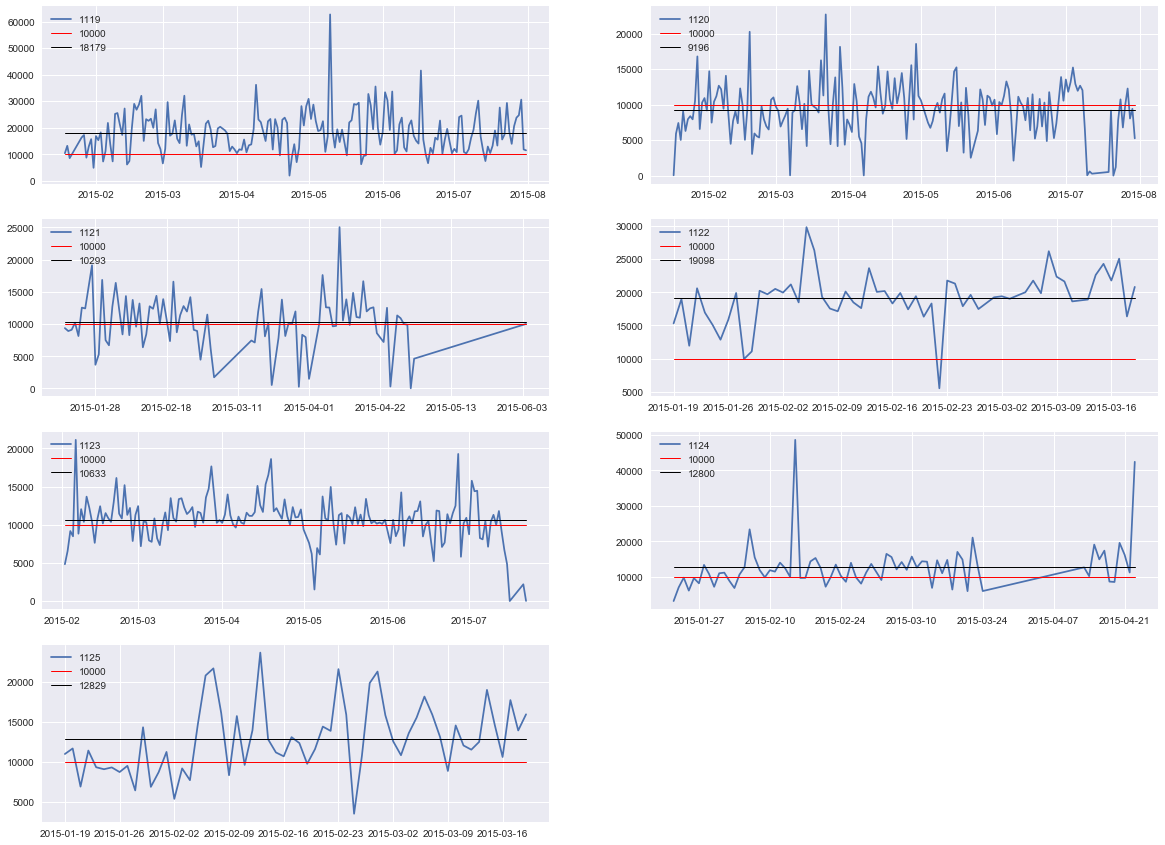

In [57]:
### en maak er eeen plot van.
stepsPlots = pl.figure(figsize=(20,15))

for idx,t in enumerate(fitbits_l):
    treatment_b = StepsPeriodC_df['T_Nr']==t
    SPTC_df = StepsPeriodC_df[treatment_b]
    pl.subplot(4,2,idx+1)
    pl.plot(SPTC_df['dateOnly'],SPTC_df['Stap'],label=SPTC_df.iloc[0,0])
    x1=SPTC_df.iloc[0,1]
    x2=SPTC_df.iloc[len(SPTC_df)-1,1]
    ygem=int(StapGemC_df.ix[(StapGemC_df['T_Nr']==t),2])
    pl.plot([x1,x2 ], [10000, 10000], color='r', linestyle='-', linewidth=1,label='10000')
    pl.plot([x1,x2 ], [ygem, ygem], color='k', linestyle='-', linewidth=1,label=ygem)
    pl.legend(loc='upper left')


pl.show()

### Gemiddeld aantal stappen per dag
Zes van de zeven kandidaten zitten in de periode waar er daadwerkelijk metingen zijn gemiddeld boven de 10000 stappen. Alleen kandidaat 1120 zit er onder met gemiddeld 9196 stappen per dag. Kandidaten 1121 (10293) en 1123 (10633) zitten net boven de 10000. De kandidaten 1124 (12800) en 1125 (12829) zitten er ruim boven. De kandidaten 1119 (18179) en 1122 (19098) zitten er heel ver boven.

## Andere tijdseenheden toevoegen

Voor het analyseren is het handig om voor elke regel de maand, dag van de week, uur en week te bepalen uit de datum en vast te leggen.

In [58]:
# voeg extra kolommen met tijdseenheden toe
FBC_df['weekdag'] = FBC_df['Datum'].dt.dayofweek #0 is monday
FBC_df['uur'] = FBC_df['Datum'].dt.hour
FBC_df['maand'] = FBC_df['Datum'].dt.month
FBC_df['week'] = FBC_df['Datum'].dt.week

In [59]:
FBC_df

,T_Nr,Datum,Stap,Afst,dateOnly,weekdag,uur,maand,week
0,1119,2015-01-19 00:00:00,0.0,0.0,2015-01-19,0,0,1,4
1,1119,2015-01-19 00:01:00,0.0,0.0,2015-01-19,0,0,1,4
2,1119,2015-01-19 00:02:00,0.0,0.0,2015-01-19,0,0,1,4
3,1119,2015-01-19 00:03:00,0.0,0.0,2015-01-19,0,0,1,4
4,1119,2015-01-19 00:04:00,0.0,0.0,2015-01-19,0,0,1,4
5,1119,2015-01-19 00:05:00,0.0,0.0,2015-01-19,0,0,1,4
6,1119,2015-01-19 00:06:00,0.0,0.0,2015-01-19,0,0,1,4
7,1119,2015-01-19 00:07:00,0.0,0.0,2015-01-19,0,0,1,4
8,1119,2015-01-19 00:08:00,0.0,0.0,2015-01-19,0,0,1,4
9,1119,2015-01-19 00:09:00,0.0,0.0,2015-01-19,0,0,1,4


## Geprepareerde data bewaren
De geschoonde en verrijkte data gaat naar een CSV bestand en serialized via Pickle.

In [60]:
FBC_df.to_csv('fitbit_schoon.csv', sep=',', encoding='utf-8',index=False)
#Maak een pickle dump voor hergebruik bij analyse en statistiek
FBC_df.to_pickle('Fitbit_schoon.pkl')